In [165]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from collections import Counter 
import matplotlib.dates as mdates
import matplotlib.ticker as plticker
import folium
import folium.plugins as plugins


from tqdm import tqdm

In [ ]:
# DHT ops by hour graph
dfDHTops = pd.read_csv("./dht/ops-by-hour.csv")

sns.set(rc={'figure.figsize':(18,12.5)})
fig, ax = plt.subplots()
plt.title("DHT events by hour of day", size=14)
sns.lineplot(data=dfDHTops, 
             x='hour',y='count', 
             hue='op', palette=sns.color_palette("Set1", 3),
             estimator=None, markers=True)
plt.savefig("ops-by-hour.png", bbox_inches='tight')
plt.close()

In [ ]:
#Cumulative count of DHT activity 
dfDHT = pd.read_csv("./dht/dht-events-raw.csv")
dfDHT['ts'] = pd.to_datetime(dfDHT['ts'])
dfDHT['total_ops'] = dfDHT.groupby('op').cumcount() + 1

fig, ax = plt.subplots()
ax.set(yscale='log')
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %R'))

sns.lineplot(data=dfDHT[0:17800], 
             x='ts',y='total_ops', hue='op',
             estimator=None, markers=True)
plt.title("6 hour DHT activity (log scale)", size=14)
plt.savefig("dht-cumulative.png", bbox_inches="tight")
plt.close()

In [ ]:
# Timeseries of unique peers seen
df = pd.read_csv("./peers/timeseries-unique-peers.summary.csv")
df['ts'] = pd.to_datetime(df['ts'])
df['avg_seen'] = df['total'].rolling(120).mean()
df['avg_unique'] = df['unique'].rolling(120).mean()
df['avg_delta'] = df['delta'].rolling(120).mean()


fig, ax = plt.subplots()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %R'))
plt.title("Known DHT peers [2 hr moving avg]", size=14)
sns.lineplot(data=df, x='ts', y='avg_seen')
plt.savefig("dht-total-known.png", bbox_inches='tight')
plt.close()

fig, ax = plt.subplots()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %R'))
plt.title("Δ(total, unique) peers [2 hr moving avg]", size=14)
sns.lineplot(data=df, x='ts', y='avg_delta')
plt.savefig("dht-delta-known.png", bbox_inches='tight')
plt.close()


In [ ]:
# Peer geolocation over time
# df = pd.read_csv("./peers/timeseries-peer-geo.csv")
df['ts'] = pd.to_datetime(df['ts'])
df['loc'] = df['lat'].map(str) + "," + df['lon'].map(str)
counts = pd.value_counts(df['loc'])

In [ ]:
# For animation... TODO
grouped = df.groupby('ts')
heatmap_data = []
for name, group in grouped:
    counter = pd.value_counts(group['loc'])
    counter = counter.to_dict()
    counter['ts'] = name
    heatmap_data.append(counter)

heatmap_tuples = []
for timestep in tqdm(heatmap_data):
    ts = timestep.pop('ts')
    for loc,count in timestep.items():
        lat, lon = loc.split(",")
        lat, lon = float(lat), float(lon)
        row = (ts, lat, lon, count)
        heatmap_tuples.append(row)

In [51]:
heatmapDf = pd.DataFrame.from_records(heatmap_tuples, columns=['ts', 'lat', 'lon', 'occurrences'])
time_index = heatmapDf['ts']
# dt_index = [item.to_pydatetime() for item in tqdm(time_index)]
ts_index = [item.strftime('%Y-%m-%d %H:%M:%S') for item in dt_index]

hmap = folium.Map(location=(0,0), zoom_start=2, tiles='cartodbdark_matter',)
hm = plugins.HeatMapWithTime(
    list(zip(heatmapDf.lat.values, heatmapDf.lon.values, heatmapDf.occurrences.values)),
    index=ts_index,
    min_opacity=0.3, max_opacity=0.9,
)

In [52]:
hm.add_to(hmap)

In [53]:
hmap.save("test.html")

In [56]:
# Activity-weighted peer geo heatmap
totalCounts = pd.value_counts( df['loc'])
totalTuples = []
for loc,count in totalCounts.items():
    lat, lon = loc.split(",")
    lat, lon = float(lat), float(lon)
    row = (lat, lon, count)
    totalTuples.append(row)
max_count = totalCounts.max()
hmap2 = folium.Map(location=(0,0), zoom_start=2, tiles='cartodbdark_matter',)
hm2 = plugins.HeatMap(
    totalTuples,
    min_opacity=0.2, max_val=max_count, radius=12, blur=12, max_zoom=1
)
hmap2.add_child(hm2)

In [57]:
hmap2.save("activity-weighted-peer-location.html")

In [90]:
# Bitswap ops
df = pd.read_csv("ops/bitswap.summary.csv")
df['ts'] = pd.to_datetime(df['ts'])
df['avg_partners'] = df['partners_size'].rolling(90).mean()

sns.set(rc={'figure.figsize':(18,12.5)})
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %R'))
plt.title("Bitswap protocol partners [3 hour moving avg]")
sns.lineplot(data=df, x='ts', y='avg_partners')
plt.savefig("bitswap-partners-avg.png", bbox_inches="tight")
plt.close()

In [92]:
# Bitswap blocks
df = pd.read_csv("ops/bitswap.stacked.csv")
df['ts'] = pd.to_datetime(df['ts'])

sns.set(rc={'figure.figsize':(18,12.5)})
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %R'))
plt.title("Bitswap protocol block activity")
sns.lineplot(data=df, x='ts', y='n_blocks', hue='block_type', palette=sns.color_palette("Set1", 3))
plt.savefig("bitswap-blocks.png", bbox_inches="tight")
plt.close()

In [ ]:
# Reshape
df = pd.read_csv("ops/bandwidth.summary.csv")
df['ts'] = pd.to_datetime(df['timestamp'])
df = df[~df.protocol.isin(['._yamux_1.0.0', '._spdy_3.1.0', '._secio_1.0.0', '._plaintext_1.0.0', '._mplex_6.7.0', '._libp2p_relay_circuit_0.1.0'])]
df['download_avg'] = df['rate_in'].rolling(10).mean()
df['upload_avg'] = df['rate_out'].rolling(10).mean()
df.to_csv("bandwidth.summary2.csv")

In [145]:
# Cumulative bandwidth
# df = pd.read_csv("ops/bandwidth.stacked.csv")
# df['ts'] = pd.to_datetime(df['timestamp'])

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %R'))
sns.lineplot(
    data=df[~df.metric.isin(['download_avg', 'upload_avg'])], 
    x='ts', y='bytes', hue='protocol', style='metric',
    palette=sns.color_palette("Set1", 6), alpha=0.7)
plt.ylabel("Bytes")
plt.title("Total bandwidth used", size=14)
plt.savefig("bw-cumulative.png", bbox_inches="tight")
plt.close()

/Users/nhf/.local/share/virtualenvs/ipfs-0_yuO8fX/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


In [164]:
bwAvgs = df[df.metric.isin(['upload_avg', 'download_avg'])]
bwAvgs = bwAvgs[ bwAvgs.protocol=='cumulative' ]

# Upload and download
sns.set(rc={'figure.figsize':(18,12.5)})
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %R'))
sns.lineplot(data=bwAvgs, x='ts', y='bytes', hue='metric', alpha=0.7)
ax.set_yscale("log")


plt.ylabel("bytes/second")
plt.title("Download and upload bandwidth rates [20 minute moving avg]", size=14)
plt.savefig("bw-rates.png", bbox_inches="tight")

plt.close()

In [166]:
df = pd.read_csv("../dht-events-timed.csv")
df.head()

/usr/local/Cellar/jupyter/1.0.0_5/libexec/vendor/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (6,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Hash,NumLinks,BlockSize,LinksSize,DataSize,CumulativeSize,Type,Timestamp,Event,ErrorMessage,ErrorType,timeout
0,zb2rhhaoeQPDA8LWjkMSNcjtsgMxyy9p1tchqeWfyPzUXSSNL,0.0,0.0,0.0,262144.0,262144.0,file,2018-11-07T18:43:11,handleAddProvider,NaN,NaN,NaN
1,zb2rhfcL6LK1VZgqBEW227ESLxJu1MSMLQcCc4gay2CJ8etZq,0.0,0.0,0.0,262144.0,262144.0,file,2018-11-07T18:43:11,handleAddProvider,NaN,NaN,NaN
2,zb2rhoec2eGefszi57nwoFVoRAWZLesRVoYC6rqPSB4wyMokb,0.0,0.0,0.0,262144.0,262144.0,file,2018-11-07T18:43:27,handleAddProvider,NaN,NaN,NaN
3,QmNf8rthDsx487QDwoGTgNu73ku8EaipZuYKtUvsphXS7i,0.0,18810.0,4.0,18806.0,18810.0,file,2018-11-07T18:43:29,handleAddProvider,NaN,NaN,NaN
4,QmNf8rthDsx487QDwoGTgNu73ku8EaipZuYKtUvsphXS7i,0.0,18810.0,4.0,18806.0,18810.0,file,2018-11-07T18:43:36,handleAddProvider,NaN,NaN,NaN


In [231]:
d2 = df[ ['NumLinks', 'BlockSize', 'DataSize', 'LinksSize', 'CumulativeSize', 'Type', 'Event'] ].dropna()
d2 = d2[d2['Type'] != 'error']
d2['TotalSize'] = d2['CumulativeSize'].round(1)

/Users/nhf/.local/share/virtualenvs/ipfs-0_yuO8fX/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


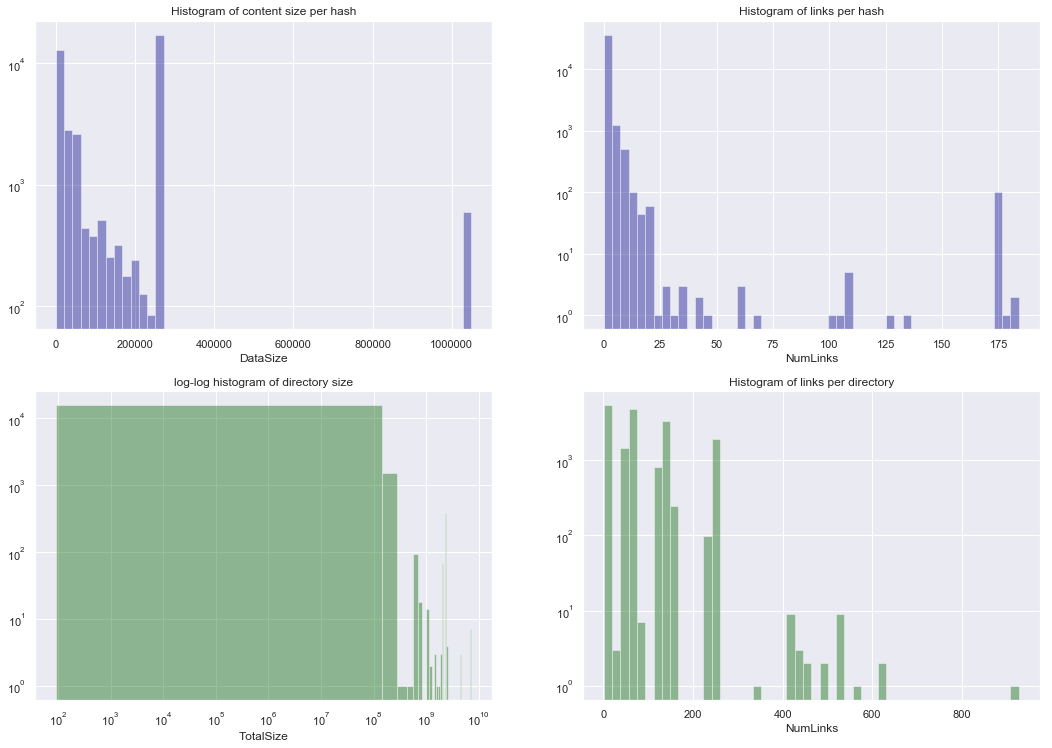

In [243]:
sns.set()
fig, axs = plt.subplots(ncols=2, nrows=2)

sns.distplot(d2[d2.Type=='file'].DataSize, kde=False, ax=axs[0][0], color='darkblue')
axs[0][0].set_title("Histogram of content size per hash")
axs[0][0].set_yscale('log')

sns.distplot(d2[d2.Type=='file'].NumLinks, kde=False, ax=axs[0][1], color='darkblue')
axs[0][1].set_title("Histogram of links per hash")
axs[0][1].set_yscale('log')

sns.distplot(d2[d2.Type=='directory']['TotalSize'], kde=False, ax=axs[1][0], color='darkgreen')
axs[1][0].set_title("log-log histogram of directory size")
axs[1][0].set_xscale('log')
axs[1][0].set_yscale('log')

sns.distplot(d2[d2.Type=='directory'].NumLinks, kde=False, ax=axs[1][1], color='darkgreen')
axs[1][1].set_title("Histogram of links per directory")
axs[1][1].set_yscale('log')


In [245]:
fig.savefig("hashstats.png", bbox_inches="tight")

In [248]:
df = pd.read_csv("./dht/dht-events-raw.csv")
df.head()

,ts,op,hash
0,2018-11-07T18:42:46,handleAddProvider,QmbAqfoR8GGb3DXtwoYeXvrjW6ugFgh9kp3mGmdJjud6tF
1,2018-11-07T18:42:46,handleGetProviders,Qmd3scwUaAH4tnU2smSXdDAFiMsxmppMpKs8zPo6jCcr5p
2,2018-11-07T18:42:48,handleAddProvider,Qmb7t9ML26cU5jnJEe3o2sdWfEng2Q1UdFWhCyviBVTGU6
3,2018-11-07T18:42:48,handleAddProvider,Qmb7t9ML26cU5jnJEe3o2sdWfEng2Q1UdFWhCyviBVTGU6
4,2018-11-07T18:42:48,handleGetProviders,QmPQpRbJFPru815fByruMmckzFmYJRLveAGc8MBJB61ZyB


/Users/nhf/.local/share/virtualenvs/ipfs-0_yuO8fX/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/Users/nhf/.local/share/virtualenvs/ipfs-0_yuO8fX/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Number of hashes')

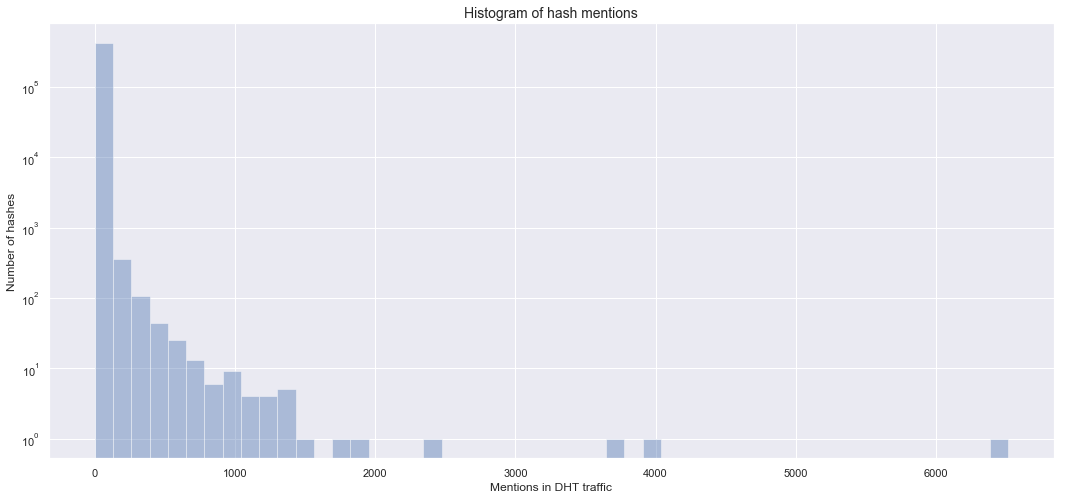

In [265]:
plt.close()
sns.set(rc={'figure.figsize':(18,8)})
counts = df.hash.value_counts()
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_title("Histogram of hash mentions", size="14")
sns.distplot(counts, kde=False)
ax.set_xlabel("Mentions in DHT traffic")
ax.set_ylabel("Number of hashes")


In [267]:
fig.savefig("dht-mentions.png", bbox_inches="tight")